In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

import scipy

from datetime import datetime

In [2]:
date=230102
n_init=1000
k = 6

in_file_name = '230102_LMM_Sp_2-3.txt'
in_ensembl_name = 'Gene_Ens_v102_canfam3.txt'
out_k_cluster_name = f'{date}_LMM_Sp_2-3_k_cl{k}'

In [3]:
pd_in = pd.read_csv(in_file_name, sep='\t', index_col=0)
pd_ens = pd.read_csv(in_ensembl_name, sep='\t', index_col=0)

### Normalization

In [4]:
np_in_z = stats.zscore(pd_in, axis=1, nan_policy='omit')
pd_in_z = pd.DataFrame(np_in_z, index=pd_in.index, columns=pd_in.columns)

### K-mean clustering

In [5]:
start = datetime.now()

km = KMeans(n_clusters=k, n_init=n_init, random_state=0)
km.fit(pd_in_z)

end = datetime.now()
print(f'Time: {end - start}')

Time: 0:00:23.240903


### Heatmap of k-means

In [6]:
pd_in_z.index = km.labels_

In [7]:
km.labels_

array([1, 4, 3, ..., 1, 1, 5])

# of gene in each cluster
cl 0 = 673
cl 1 = 675
cl 2 = 473
cl 3 = 323
cl 4 = 815
cl 5 = 411


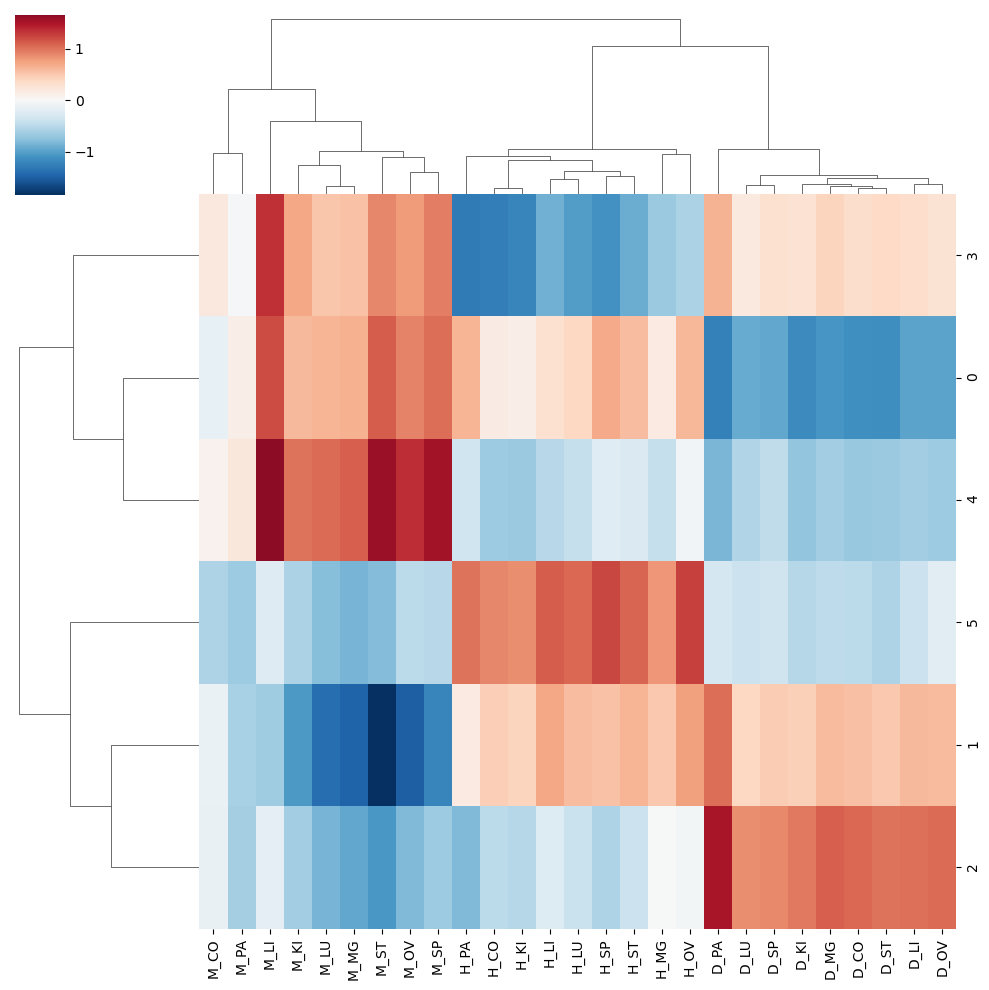

In [8]:
# Heatmap using average values
pd_in_z_mg = pd.DataFrame(index=pd_in_z.columns)

print('# of gene in each cluster')
for i in range(k):
    pd_in_z_mg[i] = pd_in_z.loc[i].mean(axis=0)
    print(f'cl {i} = {len(pd_in_z.loc[i])}')

# clustering heatmap
g=sns.clustermap(pd_in_z_mg.T, cmap='RdBu_r', center=0)
plt.savefig(f'{out_k_cluster_name}_HM_k.pdf')

In [9]:
# Extract clustering info
xaxis = g.dendrogram_col.dendrogram['leaves']
yaxis = g.dendrogram_row.dendrogram['leaves']

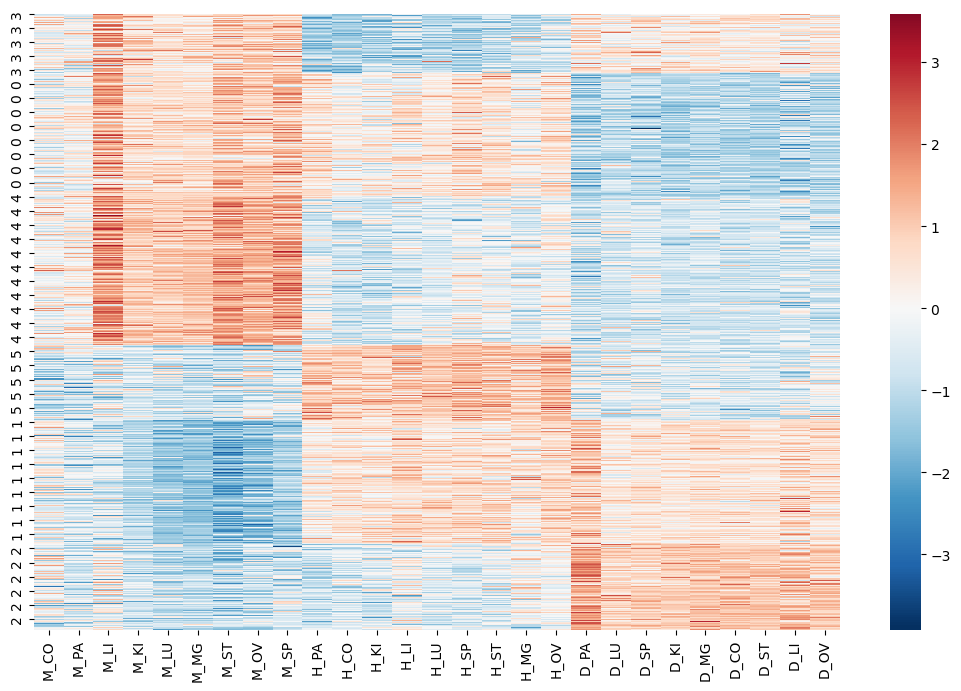

In [16]:
# Heatmap using each values
plt.figure(figsize=(13,8))
sns.heatmap(pd_in_z.loc[yaxis].iloc[:, xaxis], cmap='RdBu_r', center=0)
plt.savefig(f'{out_k_cluster_name}_HM_raw.pdf', format='pdf')

In [11]:
xaxis_edit = range(27)
yaxis_edit = [2, ]

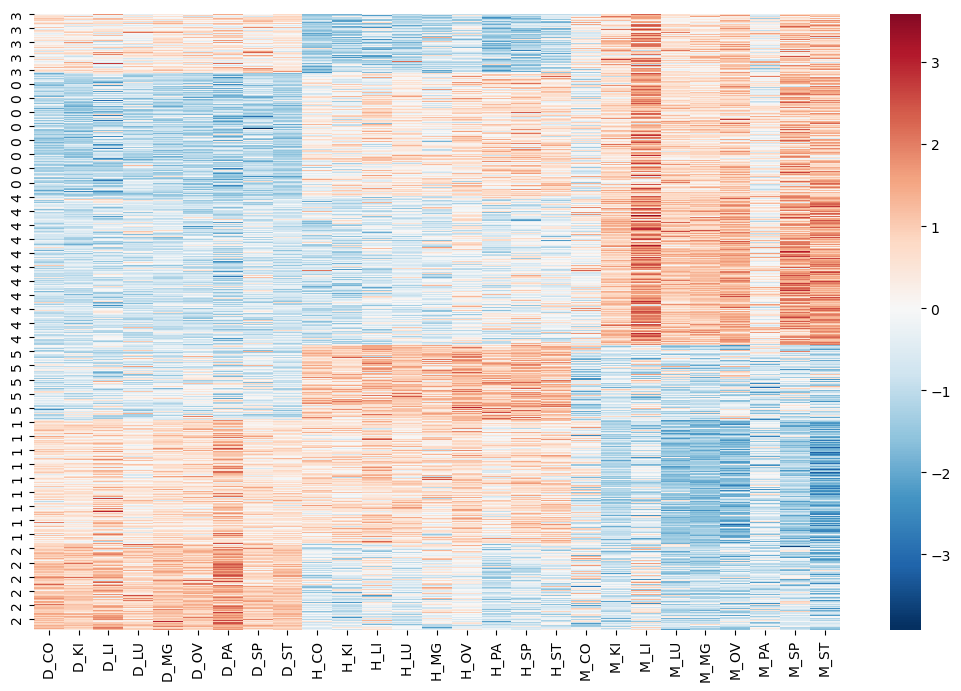

In [12]:
# Heatmap using each values
plt.figure(figsize=(13,8))
sns.heatmap(pd_in_z.loc[yaxis].iloc[:, xaxis_edit], cmap='RdBu_r', center=0)
plt.savefig(f'{out_k_cluster_name}_HM_raw_xaxis_edit.pdf')

### Extract gene-cluster info

In [11]:
pd_k_out = pd.DataFrame(km.labels_, index=pd_in.index, columns=['k_cluster'])

In [12]:
pd_k_out = pd.concat([pd_k_out, pd_ens], axis=1, join='inner')

In [13]:
pd_k_out.to_csv(f'{out_k_cluster_name}.txt', sep='\t', index=True, index_label='GeneID', header=True)

### Methods for selecting the optimal number of clusters
Ref: https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
	1. Gap Statistic
	2. Elbow Method
	3. Silhouette Coefficient
	4. Calinski-Harabasz Index
	5. Davies-Bouldin Index
	6. Dendrogram
    7. Bayesian information criterion (BIC)

In [13]:
def plot(x, y, xlabel, ylabel, title):
    plt.plot(x, y, 'bx-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# 2. Elbow Method
def elbow(X, min, max):
    n_clusters = range(min, max+1)
    sse = []
    for i in n_clusters:
        km = KMeans(n_clusters=i, n_init=n_init, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plot(n_clusters, sse, \
         'Values of K', 'SSE', \
         'elbow analysis For Optimal k')
    
# 3. Silhouette Coefficient
def sihouette(X, min, max):
    n_clusters = range(min, max+1)
    silhouette = []
    for i in n_clusters:
        km = KMeans(n_clusters=i, n_init=n_init, random_state=0)
        km.fit(X)
        silhouette.append(silhouette_score(X, km.labels_))
    
    plot(n_clusters, silhouette, \
         'Values of K', 'Silhouette score', \
         'Silhouette analysis For Optimal k')

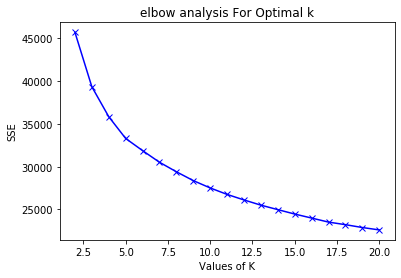

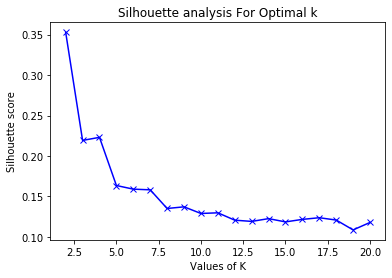

In [14]:
min, max = 2, 20
elbow(pd_in, min, max)
sihouette(pd_in, min, max)

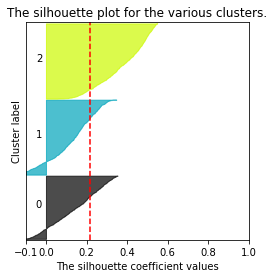

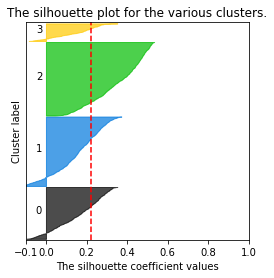

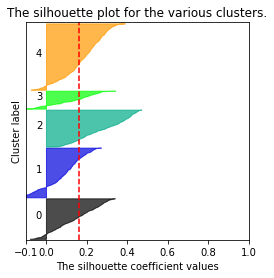

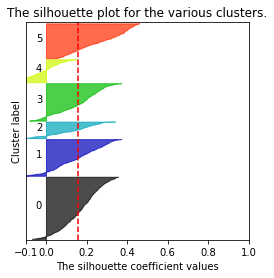

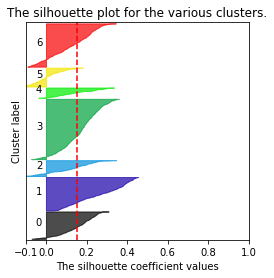

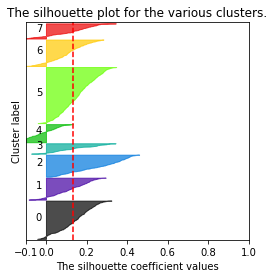

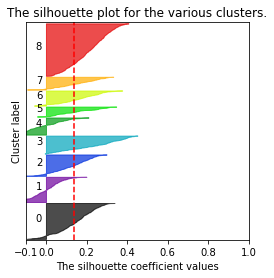

In [9]:
# 3. Silhouette Diagram
range_n_clusters = range(3, 10)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pd_in) + (n_clusters + 1) * 10])
    
    km = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=0)
    km_label = km.fit_predict(pd_in)

    score = silhouette_score(pd_in, km_label)
    values = silhouette_samples(pd_in, km_label)

    y_lower = 10
    for i in range(n_clusters):
        ith_values = values[km_label == i]
        ith_values.sort()

        size_cluster_i = ith_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=score, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()